<a href="https://colab.research.google.com/github/SteffanBurnette/Deeplearning-with-python-/blob/main/Overview_of_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Micrograd**
An **autograd(auto gradient)** engine that implements backpropagation. **Backpropagation** allows use to evaluate the **gradient** of a loss function with respect to the **weights**. We can then tune the **weights to reduce the loss**.

* **pip install micrograd**
* **Backpropagation** will start from the end of the expression graph and perform the** chain rule** (from calc) while going from end –> beginning of graph. (Each expression/operation is treated as a datatype and store in a topological manner).

* In **backpropagation** we are essentially evaluating the derivative of the last node with respect to all other nodes that have come before it.

## **The Derivative**
The **derivative** tells us how the previous values effect the end result.If you slightly move the function in a certain direction, how will that function respond. That is what the derivative tells us.

* The derivative is also know as the slope of a line

## **Neural Networks**
**Neural Networks** are essentially just mathematical expressions.

14.029999999999632

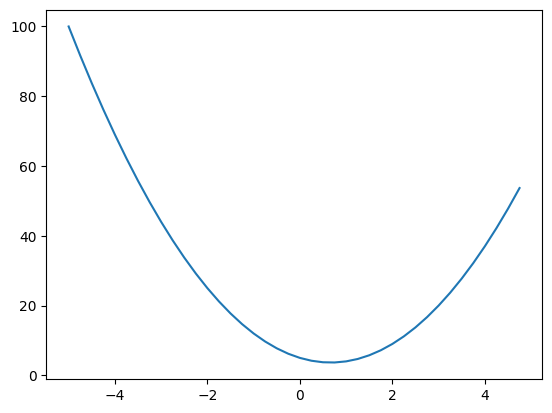

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

#A basic function
def f(x):
    return 3*x**2 - 4*x + 5
#Function call
f(3.0)

#Plotting the values in a range
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

#The effects of the derivative
h = 0.01 #The derivative
x = 3.0
#Will see how the derivative effects the function
#The derivative is the slope of the line so we can use the
#slope formula to calculate the derivative
(f(x + h) - f(x))/h

In [2]:
#More complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)


4.0


In [3]:
#The Derivative
h = 0.0001

#inputs
a = 2.0
b = -3.0
c = 10.0


d1 = a*b + c
a += h
d2 = a*b + c

#d2 will be slightly smaller then d1 because a * b will yiled a smaller number after a += h. Thus the slope will be a negative number to highlight this decrease.

print(f"D1: {d1}")
print(f"D2: {d2}")
print("Slope: ", (d2-d1)/h) #rise/run formula to calculate the slope


D1: 4.0
D2: 3.999699999999999
Slope:  -3.000000000010772


## **The Expression Graph**
The **expression graph** is a topological structure used to keep track of values/expressions so that we can tell what influenced what in the training process.

In [2]:
#Will create a basic value and calculate basic opeations
class Value:
    #The constructor
    def __init__(self, data, _children=(), _op = '', label = ''):
        self.data = data
        self._prev = set(_children) #Stores the previous values that made the current value in the set
        self._op = _op #Will store the operation used
        self.label = label
   #Returns the data in a readable format
    def __repr__(self):
        return f"Value(data = (self.data))"
    #Have to define the add operator
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+') #Instantiates the data, _children and op values
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out

#Instantiating the values
a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a*b; e.label = 'e'
d = e +c; d.label = 'd'
print(d)
#Prints out the product of a*b and the c value
print(d._prev)
#Outputs the operation used to calculate the value
print(d._op)
f = Value(-2.0, label = 'f')
L = f * d; L.label = 'L' #This is the final output of the graph

Value(data = (self.data))
{Value(data = (self.data)), Value(data = (self.data))}
+


## The Children
* The children will be the **connective tissue of the expression graphs** so that we can know what values produced what other values.
* By default the children variable will be an empty tuple: **children = ()**
* When we maitain the children in the class it will be a set dentoed by the line: **self._prev = set(_children)**
* Whenever we are perfoming mutipication/addition we will feed in the children of the value: **(self, other)**

## The Operations
* Storing the operations used to produce the current value is also important: **self._op = _op**

## Visualizing The Models Structure
* **graphviz** is an open source graph visualization software

In [3]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f}" % (n.label, n.data), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


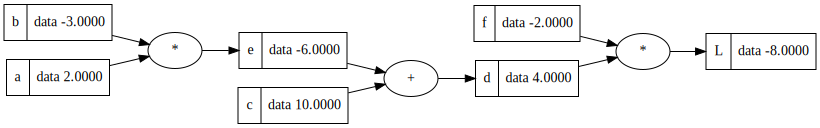

In [16]:
#Calling the function to draw the graph structure
draw_dot(L)

### Summary of what was done thus far
We are able to build out mathematical expressions by conducting a forward pass. The next step will be to perform **backpropagation** starting from the last layer (L in this case) and computer te **gradient** of all the values.



## Backpropagation
We will compute the derivative of the node with respect to **L**.

For instance, the derivative of L with respect to L is 1.

In [10]:
#Will create a basic value and calculate basic opeations
class Value:
    #The constructor
    def __init__(self, data, _children=(), _op = '', label = ''):
        self.data = data
        self.grad = 0.0 #Will be used to calculate the derivative
        #0 means no effect, so at initializing we are assuming that there is no effect
        self._prev = set(_children)
        self._op = _op #Will store the operation used
        self.label = label
   #Returns the data in a readable format
    def __repr__(self):
        return f"Value(data = (self.data))"
    #Have to define the add operator
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out

    def tanh(self):
      x = self.data
      t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
      out = Value(t, (self, ), 'tanh')
      return out

#Instantiating the values
a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a*b; e.label = 'e'
d = e +c; d.label = 'd'
print(d)
#Prints out the product of a*b and the c value
print(d._prev)
#Outputs the operation used to calculate the value
print(d._op)
f = Value(-2.0, label = 'f')
L = f * d; L.label = 'L' #This is the final output of the graph

Value(data = (self.data))
{Value(data = (self.data)), Value(data = (self.data))}
+


In [4]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


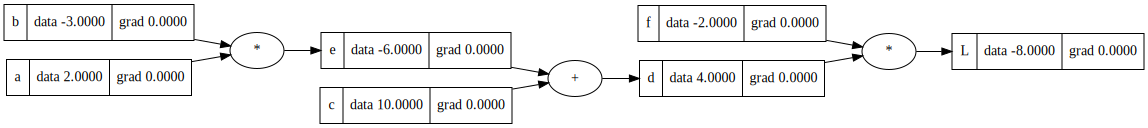

In [19]:
draw_dot(L)

#### **Evaluating The chain rule to find out the derivative**:
Thois the the rule of derivatives:

dd/dc = 1

dd/de = 1

d = e + c

- Lets say that we want to find out the impact the node c had on the final result L.We would apply the **chain rule** to figure this out:

dL/dc --> (dL/df) * (df/dc)

In [6]:
def lol():
  h = 0.001
  #Instantiating the values
  a = Value(2.0, label = 'a')
  b = Value(-3.0, label = 'b')
  c = Value(10.0, label = 'c')
  e = a*b; e.label = 'e'
  d = e +c; d.label = 'd'
  f = Value(-2.0, label = 'f')
  L = f * d; L.label = 'L' #This is the final output of the graph
  L1 = L.data



  a = Value(2.0 + h, label = 'a')
  b = Value(-3.0, label = 'b')
  c = Value(10.0, label = 'c')
  e = a*b; e.label = 'e'
  d = e +c; d.label = 'd'
  f = Value(-2.0, label = 'f')
  L = f * d; L.label = 'L' #This is the final output of the graph
  L2 = L.data

  #The derivative of L with respect to a
  #rise/run
  print((L2 - L1)/h)

  #The derivative is with respect to a becuase a is the value that was effected a little by h

## The Derivative
The **derivative** is the slope of the tangent line of a curve. The derivative the slope of a specific line. For a linear function like** y = mx + b**, the **derivative** is just **m**. Every point on the curve has the same local slope.

For quadratic functions like y = x2 the derivative is 2x. So at any point the slope of the tangent line is 2x. At x = 0, at the bottom of the parabola the derivative is 2*0 = 0. It's a flat constant line that touches the parabola at x = 0. At x = 1 the derivative is 2 times 1 or 2. At x = 2 the derivative is 2 times 2 = 4. At x = 3 the derivative is 2 times 3 = 6. So though points on y = x2 are always the square of the x value, the slope at that point is increasing by 2 times the value of x at that point.

The **derivative is the instantaneous rate of a change**. If you are traveling in a car the derivative of your distance with respect to time is your velocity. Miles per hour or kilometers per hour is your rate of change. The value of the speed on the speedometer is the rate of change right now. Your average rate of change is the total distance you traveled divided by the total time traveled over the period of interest.


🔑- A **derivative** in calculus is the **instantaneous rate of change** of a function with respect to another variable. It is also a fundamental tool of calculus that measures the **sensitivity of change** of a function's output **with respect to its input**.



**Inline Gradient check** - This is when you are deriving the **backpropagation** and getting the **derivatives** with respect to all of the intermidiate results

In [7]:
#Will be conducting the forward pass slightly optimized by the gradient
#This will reduce the final loss value
a.data = 0.001 * a.grad
b.data = 0.001 * b.grad
c.data = 0.001 * c.grad
f.data = 0.001 * f.grad

e = a * b
d = e + c
L = d * f
print (L.data)

0.0


An **activation function** is usually some type of squashing function

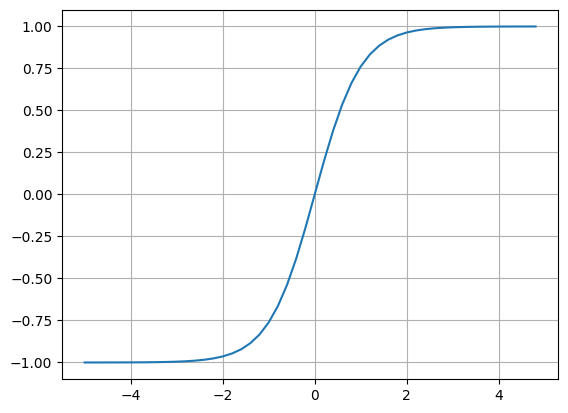

In [8]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

**tanh** is a hyperbolic function.

- Aslong as we knoiw the derivative of tanh we will be able to backpropagate through it.

In [33]:
#Constructing a Neuron

# inputs x1,x2 (Input matrix)
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2 (Weight matrix)
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron (Bias vector)
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

#Conducting the forward pass
n = x1w1x2w2 + b; n.label = 'n' # X^T * W + b
#Applying the activation function
o = n.tanh(); o.label = 'o' # tanh(X^T * W + b)

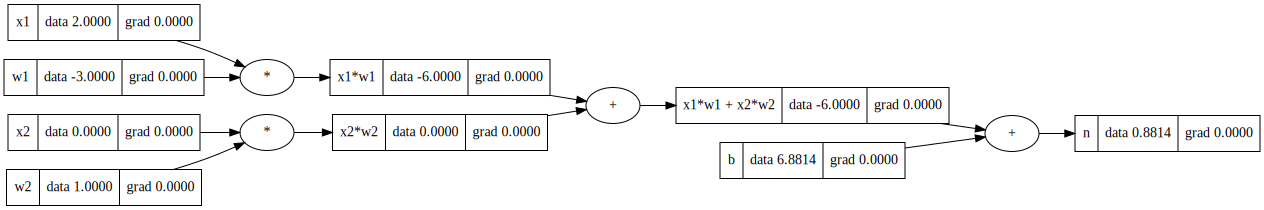

In [12]:
draw_dot(n)

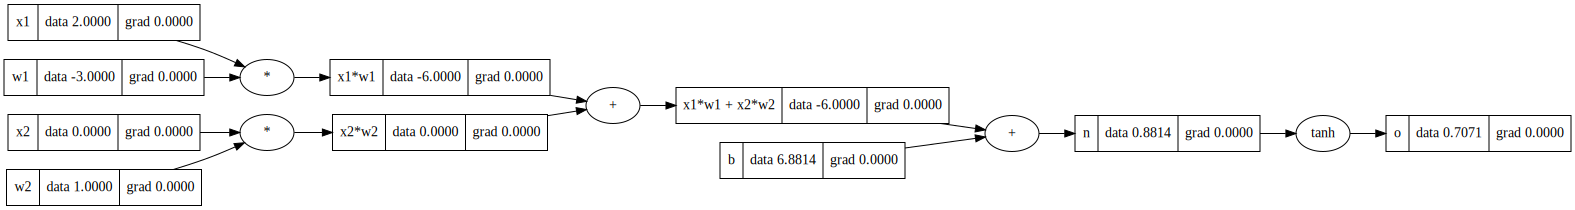

In [13]:
draw_dot(o)

**Basecase** --> The derivative of L with respect to L will always be 1.0

So, in the neuron above the first derivative, o with respect to o will be 1.0

In [14]:
#The basecase
o.grad = 1.0

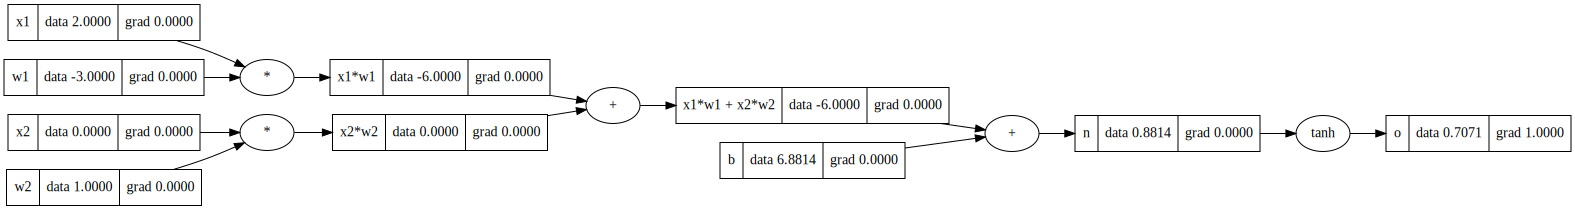

In [15]:
draw_dot(o)

Since we know what the derivative do/do is, we now need to find out what the derivative of do/dn is.

* Since we know that **o = tanh(n)**, do/dn = 1 - tanh(n)**2

 --> 1-o**2

In [19]:
1 - o.data**2 #The deriuvative of tanh

0.4999999999999999

In [18]:
#since the derivatve of o is .5 we know that the gradient of n is .5
n.grad = .5

The + operator just distributes the gradient to the recipients. so the gradients of x1w1x2w2 and b = .5 (They get the derivative from n). And the grad from x1w1 nad x2w2 = .5 since the gradient for x1w1x2w2 = .5

In [20]:
x1w1x2w2.grad = .5
b.grad = .5

##########
x1w1.grad =.5
x2w2.grad = .5

🔑- A quick reminder on what the derivative tells us at every point in time: If we want the overall outpur off the neuron to increase then the influence of positive gradients is ppsition on the output.

🔥- For the multiplication operator, to calculate the gradient of a value we need to multiply the gradient of the previous node by the value of the partner node. For example, the gradient of x2 = w2.data * x2w2.grad

In [21]:
#The chain rule
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

Since there is a * operator for x1, w1 we will follow the same principle again.

In [22]:
#The chain rule
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

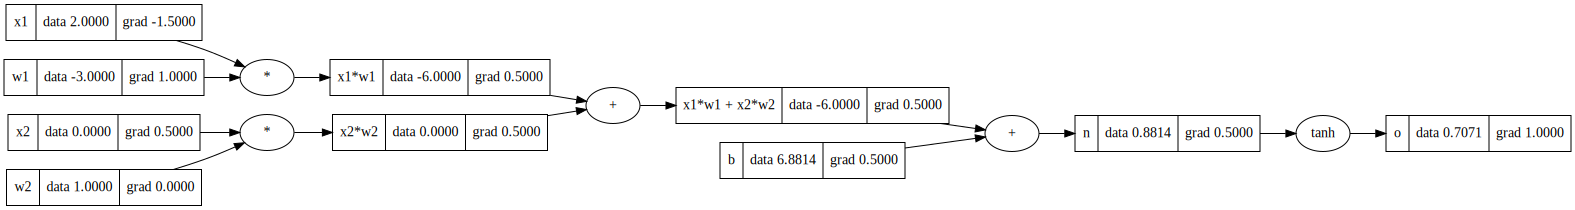

In [23]:
draw_dot(o)

NOTE: A gradient of 0 means that the value has no effect on the final output.

### Implementing an automatic backwards pass
Will now automate the backpropagation so that I dont have to calculate the derivative at every node.

In [18]:
#Will create a basic value and calculate basic opeations
class Value:
    #The constructor
    def __init__(self, data, _children=(), _op = '', label = ''):
        self.data = data
        self.grad = 0.0 #Will be used to calculate the derivative
        #0 means no effect, so at initializing we are assuming that there is no effect
        self._prev = set(_children)
        self._op = _op #Will store the operation used
        self.label = label
        #Will be a function that computes the backwards pass
        #By default is a function that does not do anything
        #All leaf nodes will not contain a backwards function
        self._backward = lambda : None
   #Returns the data in a readable format
    def __repr__(self):
        return f"Value(data = (self.data))"

    #Have to define the add operator
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward(): #Backpropagation for addition operator
          self.grad = 1.0 * out.grad  #The gloabl derivative (L) * the local derivative
          other.grad = 1.0 * out.grad

        out._backward = _backward
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward(): #Backpropagation for multiplication operator
          self.grad = other.data * out.grad  #The gloabl derivative (L) * the local derivative
          other.grad = self.data * out.grad

        out._backward = _backward
        return out

    def tanh(self):
      x = self.data
      t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
      out = Value(t, (self, ), 'tanh')

      def _backward():
          self.grad = (1 - t**2) * out.grad

      out._backward = _backward
      return out

#Instantiating the values
a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a*b; e.label = 'e'
d = e +c; d.label = 'd'
print(d)
#Prints out the product of a*b and the c value
print(d._prev)
#Outputs the operation used to calculate the value
print(d._op)
f = Value(-2.0, label = 'f')
L = f * d; L.label = 'L' #This is the final output of the graph

Value(data = (self.data))
{Value(data = (self.data)), Value(data = (self.data))}
+


In [19]:
#Constructing a Neuron

# inputs x1,x2 (Input matrix)
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2 (Weight matrix)
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron (Bias vector)
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

#Conducting the forward pass
n = x1w1x2w2 + b; n.label = 'n' # X^T * W + b
#Applying the activation function
o = n.tanh(); o.label = 'o' # tanh(X^T * W + b)

In [5]:
#The Gradients
o.grad = 1.0

#since the derivatve of o is .5 we know that the gradient of n is .5
n.grad = .5

x1w1x2w2.grad = .5
b.grad = .5
##########
x1w1.grad =.5
x2w2.grad = .5

#The chain rule
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

#The chain rule
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

In [6]:
o.grad = 1.0
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x2w2._backward()
x1w1._backward()

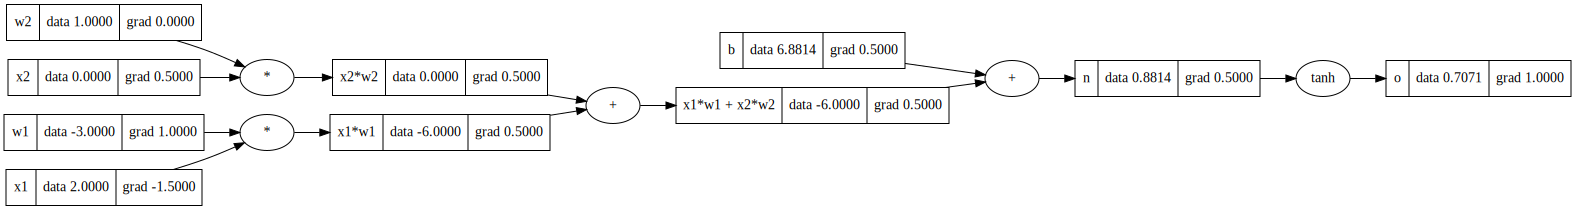

In [9]:
draw_dot(o)

## Topological Sort

We can further optimize the backpropagation process by removing the need to call it manually. This can be achived by something called **topologial sort**.

In [20]:
#Will build the topological graph
topo = []
visited = set() #Maintains a set of visited nodes
#v is the root node that we will be starting from
def build_topo(v):
  if v not in visited:
    visited.add(v) #Marks the visited node as visited
    for child in v._prev: #Goes through of the current nodes children
      build_topo(child)
    topo.append(v) #Will add itself to the topo list after all of the children has been processed

In [21]:
#Invoking the function to start from the last node (o) and build the topological graph from right to left
build_topo(o)
print(topo)

[Value(data = (self.data)), Value(data = (self.data)), Value(data = (self.data)), Value(data = (self.data)), Value(data = (self.data)), Value(data = (self.data)), Value(data = (self.data)), Value(data = (self.data)), Value(data = (self.data)), Value(data = (self.data))]


With the **topological graph** constructed we can now call **._backward** on all of the nodes in a **topological order**

In [26]:
o.grad = 1.0 #Basecase
for node in reversed(topo): #Will need to go through the nodes in reversed order
  node._backward()

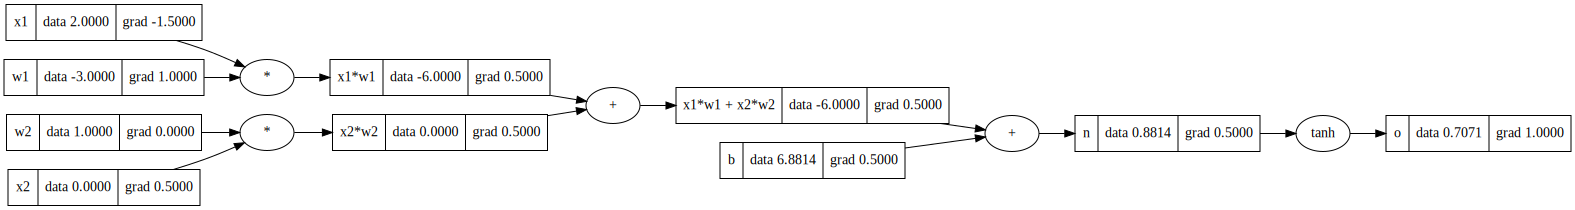

In [27]:
draw_dot(o)

### Implementing the automatic backpropagation into the class


In [29]:
#Will create a basic value and calculate basic opeations
class Value:
    #The constructor
    def __init__(self, data, _children=(), _op = '', label = ''):
        self.data = data
        self.grad = 0.0 #Will be used to calculate the derivative
        #0 means no effect, so at initializing we are assuming that there is no effect
        self._prev = set(_children)
        self._op = _op #Will store the operation used
        self.label = label
        #Will be a function that computes the backwards pass
        #By default is a function that does not do anything
        #All leaf nodes will not contain a backwards function
        self._backward = lambda : None
   #Returns the data in a readable format
    def __repr__(self):
        return f"Value(data = (self.data))"

    #Have to define the add operator
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward(): #Backpropagation for addition operator
          self.grad = 1.0 * out.grad  #The gloabl derivative (L) * the local derivative
          other.grad = 1.0 * out.grad

        out._backward = _backward
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward(): #Backpropagation for multiplication operator
          self.grad = other.data * out.grad  #The gloabl derivative (L) * the local derivative
          other.grad = self.data * out.grad

        out._backward = _backward
        return out

    def tanh(self):
      x = self.data
      t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
      out = Value(t, (self, ), 'tanh')

      def _backward():
          self.grad = (1 - t**2) * out.grad

      out._backward = _backward
      return out

    #This method computes the backpropagation for the entire graph automaically by constructing the topological graph
    #Establishing the base case of the root node and calculating the gradient of each child
    def backward(self):
      #Will first build the topological graph starting at self
     topo = []
     visited = set()
     def build_topo(v):
       if v not in visited:
         visited.add(v)
         for child in v._prev:
           build_topo(child)
         topo.append(v)
     build_topo(self)

     self.grad = 1.0
     for node in reversed(topo):
       node._backward()



Now we can reconstruct the neuron and test to see if the **automatic backpropagation** works.

In [30]:
#Constructing a Neuron

# inputs x1,x2 (Input matrix)
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2 (Weight matrix)
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron (Bias vector)
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

#Conducting the forward pass
n = x1w1x2w2 + b; n.label = 'n' # X^T * W + b
#Applying the activation function
o = n.tanh(); o.label = 'o' # tanh(X^T * W + b)

In [31]:
#Invoking the automatic backpropagation
o.backward()

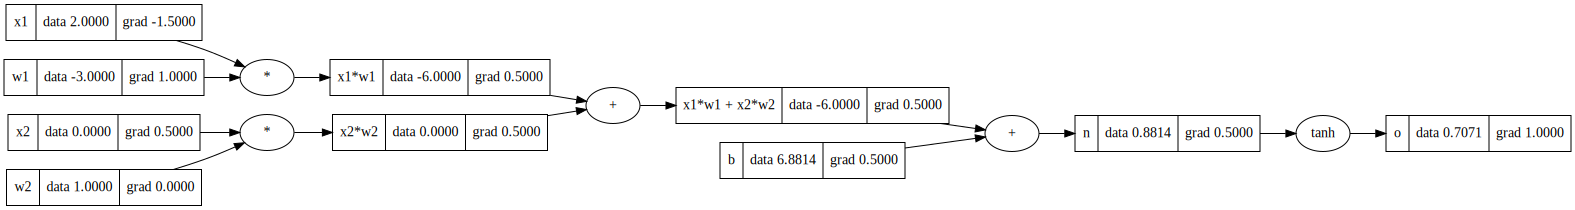

In [32]:
draw_dot(o)

An issue that we will run into with our logic is if a variable is used more than once. Instead of storing it as two seperate children it will overwrite the value being reused which will cause the calculated gradient to be inccorect.

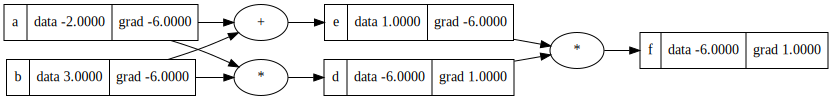

In [33]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

To fix this issue we look at the **multivariable case** of the **chain rule.** We will have to accumulate the gradients (add them). To do so we use **+=**. With this any contribution that flows backwards will add.

In [2]:
#Will create a basic value and calculate basic opeations
class Value:
    #The constructor
    def __init__(self, data, _children=(), _op = '', label = ''):
        self.data = data
        self.grad = 0.0 #Will be used to calculate the derivative
        #0 means no effect, so at initializing we are assuming that there is no effect
        self._prev = set(_children)
        self._op = _op #Will store the operation used
        self.label = label
        #Will be a function that computes the backwards pass
        #By default is a function that does not do anything
        #All leaf nodes will not contain a backwards function
        self._backward = lambda : None
   #Returns the data in a readable format
    def __repr__(self):
        return f"Value(data = (self.data))"

    #Have to define the add operator
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward(): #Backpropagation for addition operator
          self.grad += 1.0 * out.grad  #The gloabl derivative (L) * the local derivative
          other.grad += 1.0 * out.grad

        out._backward = _backward
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward(): #Backpropagation for multiplication operator
          self.grad += other.data * out.grad  #The gloabl derivative (L) * the local derivative
          other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def tanh(self):
      x = self.data
      t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
      out = Value(t, (self, ), 'tanh')

      def _backward(): #Backpropagation of tanh
          self.grad += (1 - t**2) * out.grad

      out._backward = _backward
      return out

    #This method computes the backpropagation for the entire graph automaically by constructing the topological graph
    #Establishing the base case of the root node and calculating the gradient of each child
    def backward(self):
      #Will first build the topological graph starting at self
     topo = []
     visited = set()
     def build_topo(v):
       if v not in visited:
         visited.add(v)
         for child in v._prev:
           build_topo(child)
         topo.append(v)
     build_topo(self)

     self.grad = 1.0
     for node in reversed(topo):
       node._backward()



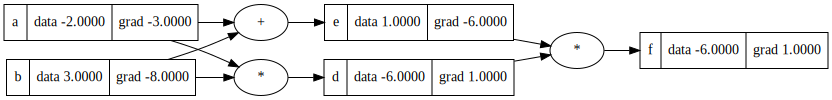

In [5]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

### tanh
Will go through the other forms of the **derivative** of **tanh** to show that it will yeild the same result reguardless of what form of its derivative you choose.

a/b is the same as:
* a * (1/b)
* a * b^-1

## Pytorch
Will now implement the same neuron functionality in **pytorch**.

In [6]:
import torch
import random
#.double() nis type casting the tensor to double
#This is because by default the datatype of the tensors is float
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b  #Forward pass
o = torch.tanh(n)  #Activation function

print(o.data.item())
o.backward() #Backpropagation

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [9]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward

    return out


  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

**What is a layer** - A set of neurons evaluated independently. Essentially a **layer** is just a list of **neurons**.

* **loss** - A single value that is used to describe the performance of the neural network.

In [15]:
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)] #Random value between -1 and 1
    self.b = Value(random.uniform(-1,1))

 #When the class neuron is called as a function this method will be invoked
  def __call__(self, x):
    # w * x + b
    #Performs the dot product
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout): #nin is the number of inputs, nout is the number of neurons in the layer
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

#Multi-layer perceptron
class MLP:

  def __init__(self, nin, nouts): #nouts is multiple layers
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [16]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.6193301777833572)

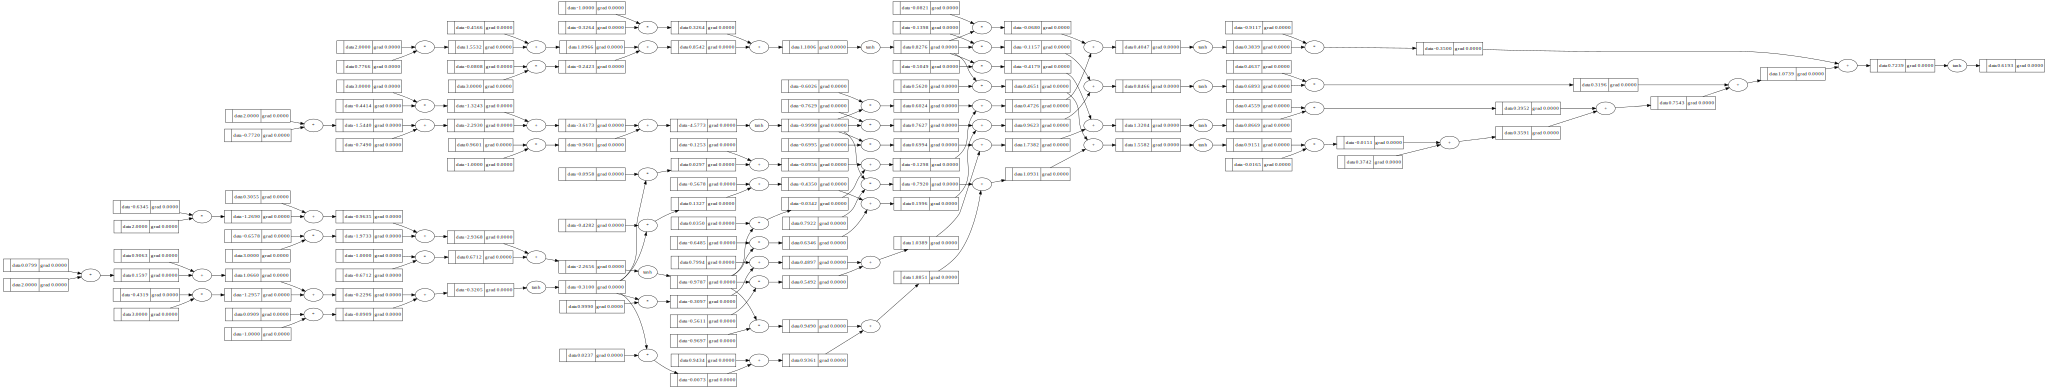

In [17]:
draw_dot(n(x))

### Simple Artificial Dataset

In [13]:
#Features
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets (labels)

### Gradient Descent
In **gradient descent** we are thinking of the **gradient** as a **vector** pointing in the direction of **increased loss** (the direction of increasing the loss). In **gradient descent** we are modifying p.data by a small step size in the opposite direction of the gradient.

In [18]:
#The Training loop
for k in range(20): #Training for 20 epochs

  # forward pass
  ypred = [n(x) for x in xs]
  #ygt is the ground truth(actual value), yout is the prediction ,made
  #zip allows us to loop through both the actual value and the predicted value at the same time
  #sum((yout - ygt))**2 is the mean squared error
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # backward pass
  #Setting the gradient back to 0 before the backwards pass is invoked to ensure no errors

  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update (gradient descent)
  for p in n.parameters():
    p.data += -0.1 * p.grad

  print(k, loss.data)

0 5.6378216842150275
1 5.072246205334473
2 4.956044066775837
3 4.591439964741577
4 4.234227312686627
5 3.7681425456353566
6 2.2372378309182515
7 0.26603295178209785
8 0.04957322012821805
9 0.0402843807075806
10 0.03463257262118313
11 0.030709776693143294
12 0.02776561934565735
13 0.025439582499570883
14 0.023534894652126763
15 0.021933980553023362
16 0.020561614279709546
17 0.019367011613825556
18 0.018314375268668907
19 0.017377563544462904


If calculated **gradient** is negative that means that the value will cause the **loss** to go down. So you wiuyld want to tune the weights with that value.

* **parameters** - All of the weights and biases within the neural network.

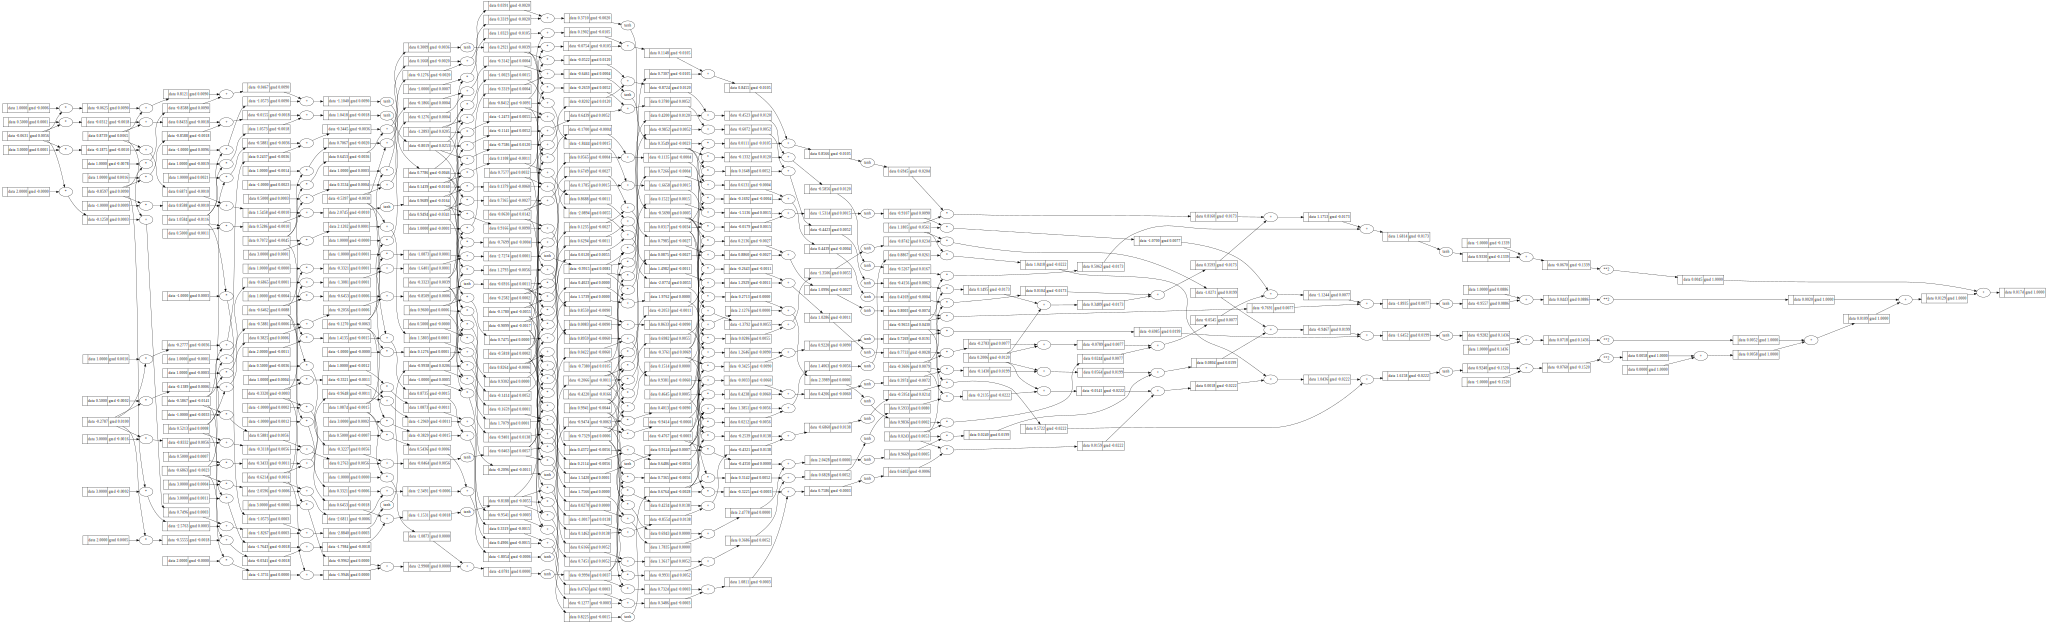

In [19]:
draw_dot(loss)

## Summary
**What are neural networks** --> **Neural Networks** are mathematical expressions that takes data as inputs, weights and  bias to conduct the mathematical expression (**forward pass**). Next the **loss function** computes the loss score of the network after the **forward pass** to get an idea on how the neural network is performing (the **accuracy** of the predictions). The we perform **backpropagation** to compute the **gradients** of the network so that we can tune the parameters (weights) in a direction (oppoosite direction of the gradients) to reduce the loss. We iterate this process many times and this method is called **gradient descent**.

gpt --> take a few words and try to predict the next word in the sequence.

## Google gemini 2.5 pro
In the field of AI, a system’s capacity for “reasoning” refers to more than just classification and prediction. It refers to its ability to analyze information, draw logical conclusions, incorporate context and nuance, and make informed decisions.

For a long time, we’ve explored ways of making AI smarter and more capable of reasoning through techniques like reinforcement learning and chain-of-thought prompting.